In [197]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim
import time
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")

In [198]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Dataset
https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

# 1a: Read, preprocess, and print main statistics about the dataset

In [218]:
# Pandas Dataframe
data = pd.read_csv('Tweets.csv')

In [219]:
print("Dataset Shape:", data.shape)

Dataset Shape: (14640, 15)


In [220]:
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null 

In [221]:
print("\nDataset Statistics:")
data.describe()


Dataset Statistics:


,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [222]:
# Display first five rows of dataframe
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [223]:
# Only keep necessary columns and remove unnecessary ones
data = data[['airline_sentiment', 'text']]

# Check for missing values
print("Missing Values:")
print(data.isnull().sum())

Missing Values:
airline_sentiment    0
text                 0
dtype: int64


In [224]:
# Text preprocessing
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to the 'text' column
data['clean_text'] = data['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guptan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/guptan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1b: Data Visualization

In [234]:
palette_color = sns.color_palette('bright') 

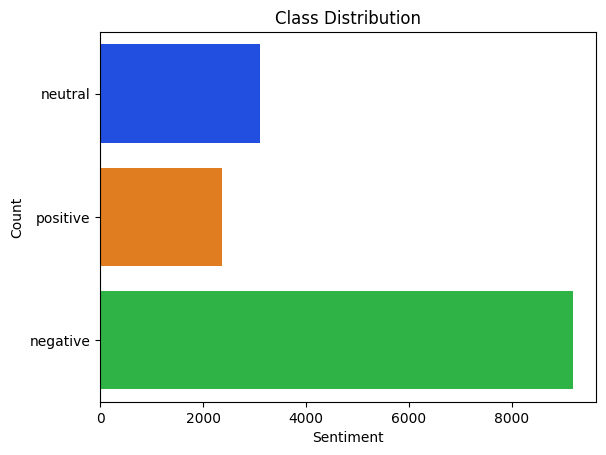

In [235]:
# Visualize airline sentiment distribution
sns.countplot(data['airline_sentiment'], palette=palette_color)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

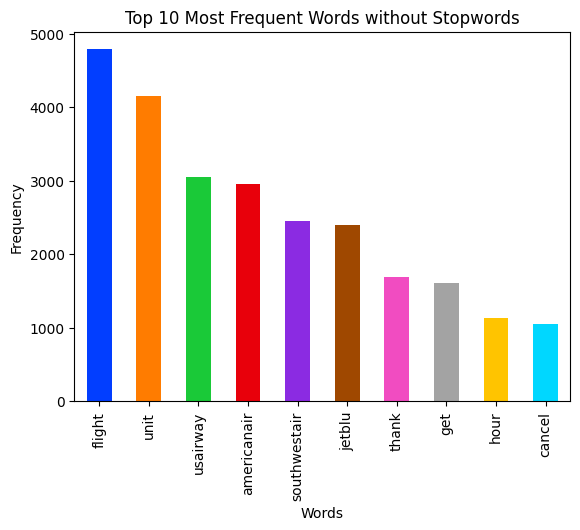

In [236]:
# Visualize word frequency distribution
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['clean_text'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq.sum().sort_values(ascending=False).head(10).plot(kind='bar', color=palette_color)
plt.title('Top 10 Most Frequent Words without Stopwords')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

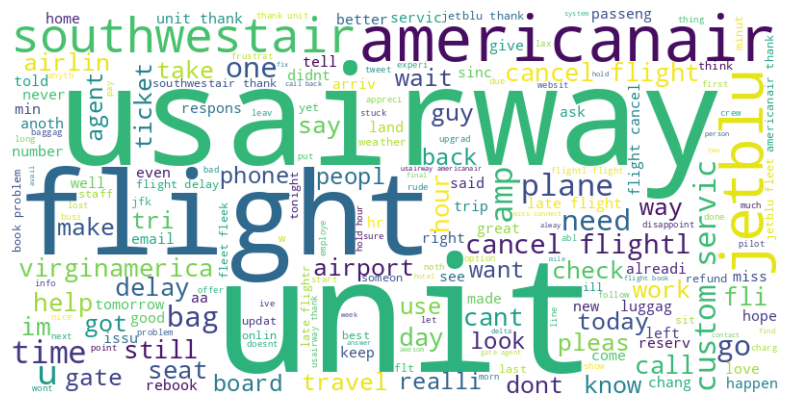

In [237]:
# Combine all clean_text into a single string
all_clean_text = ' '.join(data['clean_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_clean_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 1c: Prepare the dataset for training

In [238]:
# Encoding text-Encode the preprocessed text into numerical representations
vectorizer = CountVectorizer()

# Fit and transform the clean text
X = vectorizer.fit_transform(data['clean_text']).toarray()

In [239]:
# Prepare target variable-Encode the target variable (airline_sentiment) into numerical labels
label_encoder = LabelEncoder()

# Encode the target variable
y = label_encoder.fit_transform(data['airline_sentiment'])

In [323]:
# Split dataset into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [242]:
# Print the shape of each tensor
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([11712, 13811])
X_val_tensor shape: torch.Size([1464, 13811])
X_test_tensor shape: torch.Size([1464, 13811])
y_train_tensor shape: torch.Size([11712])
y_val_tensor shape: torch.Size([1464])
y_test_tensor shape: torch.Size([1464])


### LSTM Model Architecture

In [393]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropoutAdd=False):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropoutAdd = dropoutAdd
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim,
                            batch_first=True, dropout=0.5 if dropoutAdd else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Add a sequence length dimension
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        if self.dropoutAdd:
            # Apply dropout
            out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [394]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]  # Input size is the number of features
hidden_size = 128  # Number of features in the hidden state
num_layers = 3  # Number of LSTM layers
output_size = len(label_encoder.classes_)  # Output size is the number of classes

In [395]:
# Print the model architecture
print(LSTM(input_size, hidden_size, num_layers, output_size))

LSTM(
  (lstm): LSTM(13811, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [413]:
def modelTraining(model, criterion, optimizer, earlyStopping=False):
    import time

    startTime = time.time()

    training_loss_plt_arr = []
    validation_loss_plt_arr = []
    testing_loss_plt_arr = []

    epochs = 20
    max_consecutive = 0
    consecutive_count = 0
    previous_number = float('inf')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, (texts, labels) in enumerate(train_loader):
            outputs = model(texts)
            loss_training = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss_training.backward()
            optimizer.step()

            running_loss += loss_training.item()            

            if i % 100 == 99:
                validation_loss = 0.0
                with torch.no_grad():
                    for texts, labels in val_loader:
                        outputs = model(texts)
                        loss_validation = criterion(outputs, labels)
                        validation_loss += loss_validation.item()

                testing_loss = 0.0
                with torch.no_grad():
                    for texts, labels in test_loader:
                        outputs = model(texts)
                        loss_testing = criterion(outputs, labels)
                        testing_loss += loss_testing.item()

                training_loss = round((running_loss / 100), 3)
                validation_loss = round((validation_loss / len(val_loader)), 3)
                testing_loss = round((testing_loss / len(test_loader)), 3)

                print(
                    f"[{epoch + 1}, {i + 1}], Training loss: {training_loss}, Validation loss: {validation_loss}, Testing loss: {testing_loss}")

                training_loss_plt_arr.append(training_loss)
                validation_loss_plt_arr.append(validation_loss)
                testing_loss_plt_arr.append(testing_loss)
                running_loss = 0.0

                # Early stopping condition
                if earlyStopping:
                    if validation_loss < previous_number:
                        previous_number = validation_loss
                        consecutive_count = 0
                    else:
                        consecutive_count += 1
                        max_consecutive = max(
                            max_consecutive, consecutive_count)
                        if max_consecutive == 5:
                            print(
                                "\nStopping training as Validation Loss stopped improving.")
                            break

        if earlyStopping:
            if max_consecutive == 5:
                break

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")

    return training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr


In [399]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [401]:
# Updated Performance Evaluation
def loadersAccuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []

    with torch.no_grad():
        for data in loader:
            texts, labels = data
            # Move images and labels to GPU
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())

    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels


def perfEvaluation(model):
    model.eval()

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels = loadersAccuracy(
        test_loader, model)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _ = loadersAccuracy(val_loader, model)
    train_accuracy, _, _ = loadersAccuracy(train_loader, model)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f'{v:.2f}', color='black', ha='center')
    plt.show()

     # Plot Confusion Matrix
    class_labels = label_encoder.classes_
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

### LSTM Model

[1, 100], Training loss: 1.102, Validation loss: 1.093, Testing loss: 1.091
[1, 200], Training loss: 1.08, Validation loss: 1.07, Testing loss: 1.066
[1, 300], Training loss: 1.054, Validation loss: 1.033, Testing loss: 1.027
[2, 100], Training loss: 0.949, Validation loss: 0.896, Testing loss: 0.877
[2, 200], Training loss: 0.861, Validation loss: 0.841, Testing loss: 0.811
[2, 300], Training loss: 0.857, Validation loss: 0.82, Testing loss: 0.788
[3, 100], Training loss: 0.796, Validation loss: 0.788, Testing loss: 0.752
[3, 200], Training loss: 0.765, Validation loss: 0.769, Testing loss: 0.732
[3, 300], Training loss: 0.788, Validation loss: 0.753, Testing loss: 0.718
[4, 100], Training loss: 0.712, Validation loss: 0.725, Testing loss: 0.687
[4, 200], Training loss: 0.693, Validation loss: 0.711, Testing loss: 0.673
[4, 300], Training loss: 0.704, Validation loss: 0.699, Testing loss: 0.662
[5, 100], Training loss: 0.676, Validation loss: 0.682, Testing loss: 0.646
[5, 200], Train

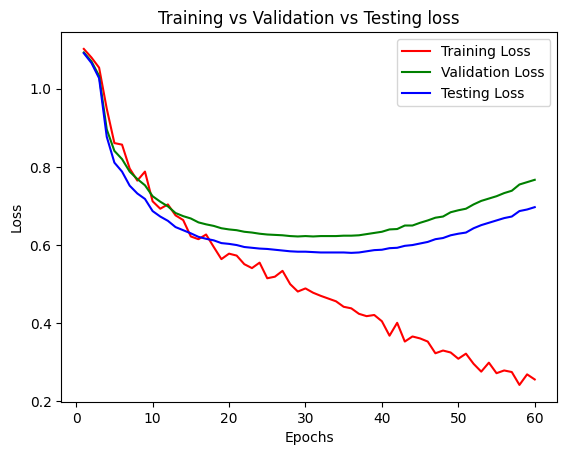

Accuracy on the testing dataset = 77.66
Precision = 0.78
Recall = 0.78
Fscore = 0.78


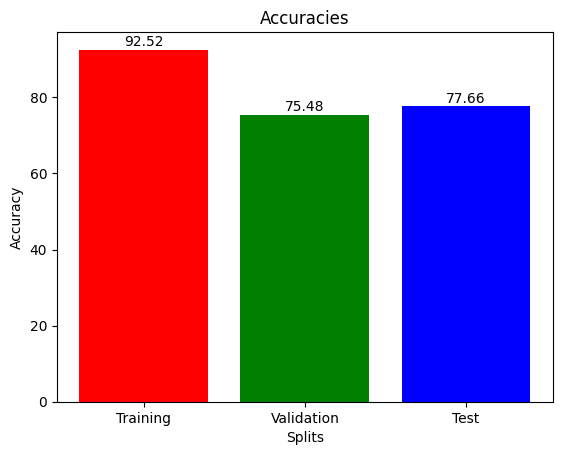

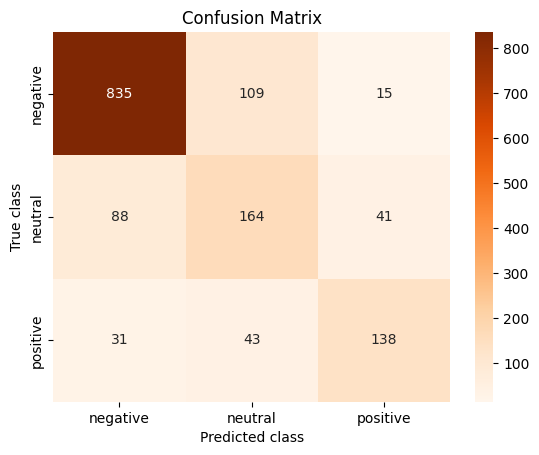

In [409]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 3
output_size = len(label_encoder.classes_)

LSTM_M1 = LSTM(input_size, hidden_size, num_layers,
               output_size, dropoutAdd=False)

criterion_M1 = nn.CrossEntropyLoss()
optimizer_M1 = optim.Adam(LSTM_M1.parameters(), lr=0.0001)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=LSTM_M1, criterion=criterion_M1,
                                                                                     optimizer=optimizer_M1, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=LSTM_M1)

### LSTM Model with Regularization

[1, 100], Training loss: 1.11, Validation loss: 1.101, Testing loss: 1.101
[1, 200], Training loss: 1.092, Validation loss: 1.081, Testing loss: 1.08
[1, 300], Training loss: 1.07, Validation loss: 1.057, Testing loss: 1.054
[2, 100], Training loss: 1.018, Validation loss: 0.997, Testing loss: 0.988
[2, 200], Training loss: 0.976, Validation loss: 0.947, Testing loss: 0.932
[2, 300], Training loss: 0.933, Validation loss: 0.903, Testing loss: 0.882
[3, 100], Training loss: 0.889, Validation loss: 0.871, Testing loss: 0.843
[3, 200], Training loss: 0.888, Validation loss: 0.858, Testing loss: 0.829
[3, 300], Training loss: 0.857, Validation loss: 0.842, Testing loss: 0.811
[4, 100], Training loss: 0.841, Validation loss: 0.813, Testing loss: 0.78
[4, 200], Training loss: 0.809, Validation loss: 0.79, Testing loss: 0.756
[4, 300], Training loss: 0.797, Validation loss: 0.768, Testing loss: 0.734
[5, 100], Training loss: 0.752, Validation loss: 0.732, Testing loss: 0.697
[5, 200], Trainin

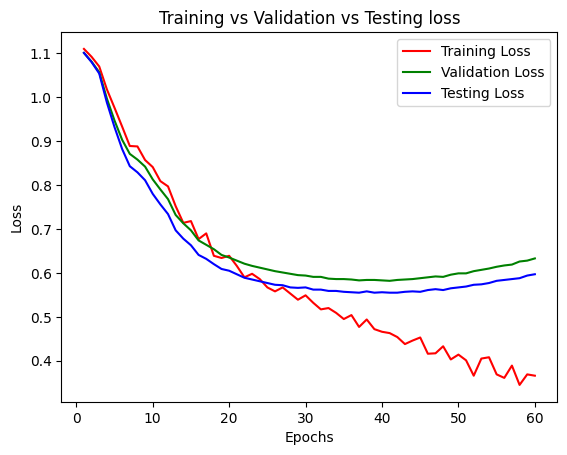

Accuracy on the testing dataset = 78.76
Precision = 0.79
Recall = 0.79
Fscore = 0.79


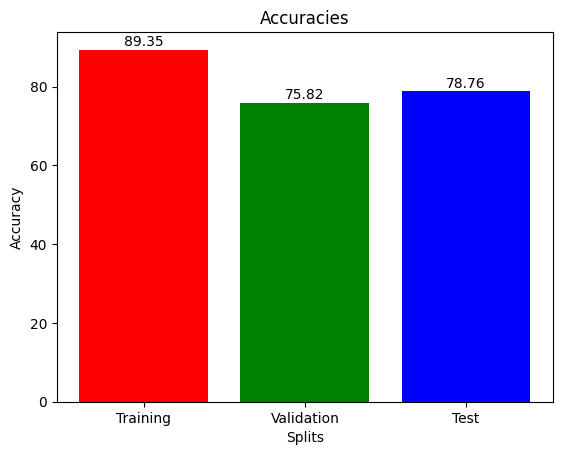

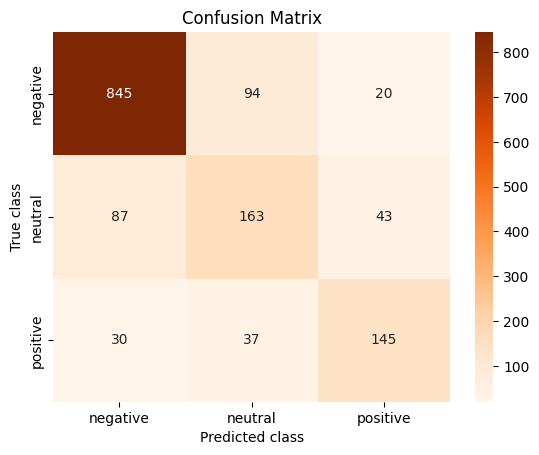

In [411]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 3
output_size = len(label_encoder.classes_)

LSTM_M2 = LSTM(input_size, hidden_size, num_layers,
               output_size, dropoutAdd=False)

# Regularization (L2)
l2_reg = 0.001
criterion_M2 = nn.CrossEntropyLoss()
optimizer_M2 = optim.Adam(LSTM_M2.parameters(), lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=LSTM_M2, criterion=criterion_M2,
                                                                                     optimizer=optimizer_M2, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=LSTM_M2)

### LSTM Model with Regularization and Dropout

[1, 100], Training loss: 1.033, Validation loss: 1.024, Testing loss: 1.019
[1, 200], Training loss: 1.025, Validation loss: 1.01, Testing loss: 1.006
[1, 300], Training loss: 1.007, Validation loss: 0.998, Testing loss: 0.991
[2, 100], Training loss: 0.981, Validation loss: 0.97, Testing loss: 0.962
[2, 200], Training loss: 0.975, Validation loss: 0.955, Testing loss: 0.946
[2, 300], Training loss: 0.96, Validation loss: 0.939, Testing loss: 0.926
[3, 100], Training loss: 0.933, Validation loss: 0.92, Testing loss: 0.903
[3, 200], Training loss: 0.936, Validation loss: 0.912, Testing loss: 0.89
[3, 300], Training loss: 0.921, Validation loss: 0.906, Testing loss: 0.884
[4, 100], Training loss: 0.914, Validation loss: 0.893, Testing loss: 0.868
[4, 200], Training loss: 0.891, Validation loss: 0.888, Testing loss: 0.861
[4, 300], Training loss: 0.903, Validation loss: 0.883, Testing loss: 0.854
[5, 100], Training loss: 0.88, Validation loss: 0.863, Testing loss: 0.84
[5, 200], Training 

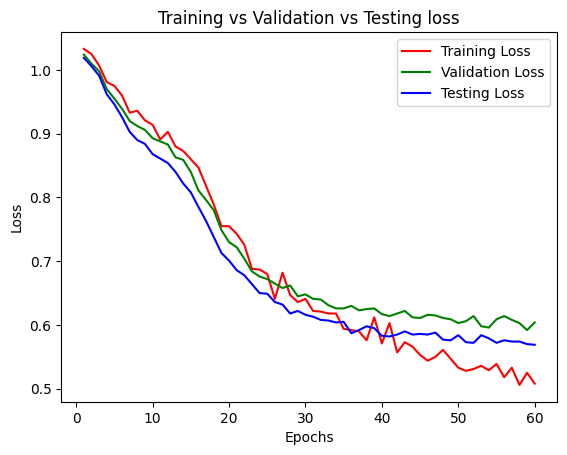

Accuracy on the testing dataset = 78.48
Precision = 0.77
Recall = 0.78
Fscore = 0.77


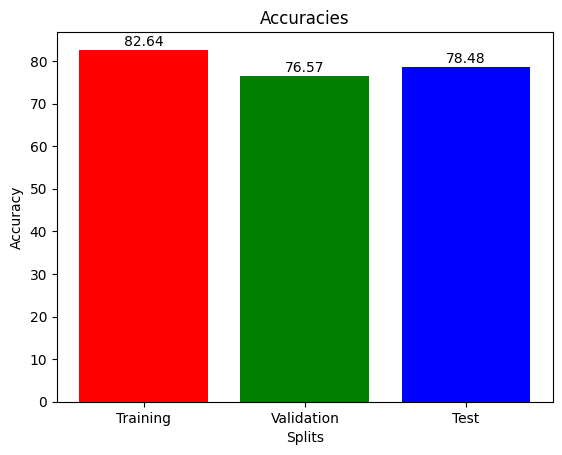

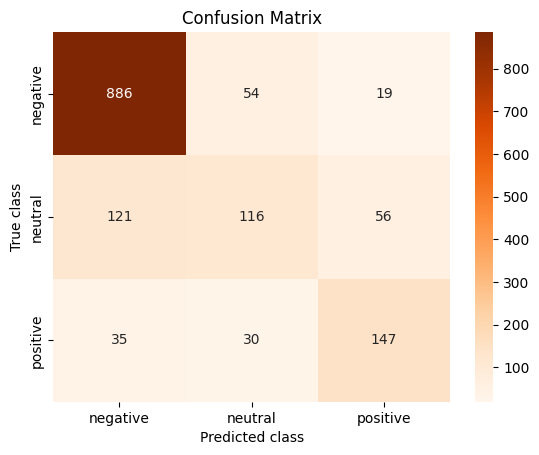

In [410]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 3
output_size = len(label_encoder.classes_)

LSTM_M3 = LSTM(input_size, hidden_size, num_layers,
               output_size, dropoutAdd=True)

# Regularization (L2)
l2_reg = 0.001
criterion_M3 = nn.CrossEntropyLoss()
optimizer_M3 = optim.Adam(LSTM_M3.parameters(), lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=LSTM_M3, criterion=criterion_M3,
                                                                                     optimizer=optimizer_M3, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=LSTM_M3)

### LSTM Model with Regularization, Dropout and Early Stopping

[1, 100], Training loss: 1.075, Validation loss: 1.065, Testing loss: 1.063
[1, 200], Training loss: 1.058, Validation loss: 1.049, Testing loss: 1.044
[1, 300], Training loss: 1.042, Validation loss: 1.032, Testing loss: 1.027
[2, 100], Training loss: 1.008, Validation loss: 0.997, Testing loss: 0.991
[2, 200], Training loss: 0.999, Validation loss: 0.979, Testing loss: 0.968
[2, 300], Training loss: 0.975, Validation loss: 0.96, Testing loss: 0.942
[3, 100], Training loss: 0.939, Validation loss: 0.92, Testing loss: 0.899
[3, 200], Training loss: 0.927, Validation loss: 0.908, Testing loss: 0.884
[3, 300], Training loss: 0.908, Validation loss: 0.898, Testing loss: 0.871
[4, 100], Training loss: 0.895, Validation loss: 0.884, Testing loss: 0.855
[4, 200], Training loss: 0.903, Validation loss: 0.876, Testing loss: 0.849
[4, 300], Training loss: 0.878, Validation loss: 0.863, Testing loss: 0.836
[5, 100], Training loss: 0.86, Validation loss: 0.842, Testing loss: 0.809
[5, 200], Train

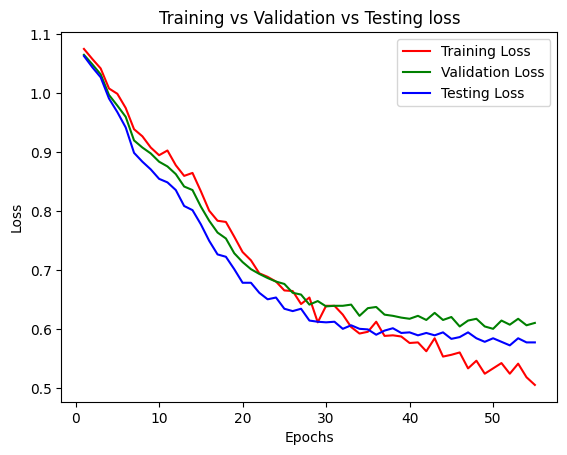

Accuracy on the testing dataset = 78.07
Precision = 0.76
Recall = 0.78
Fscore = 0.77


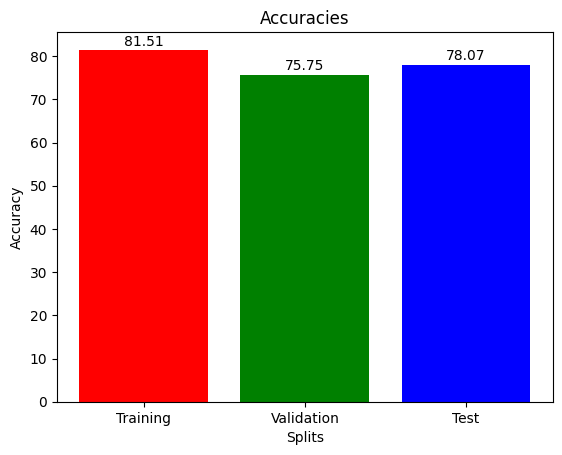

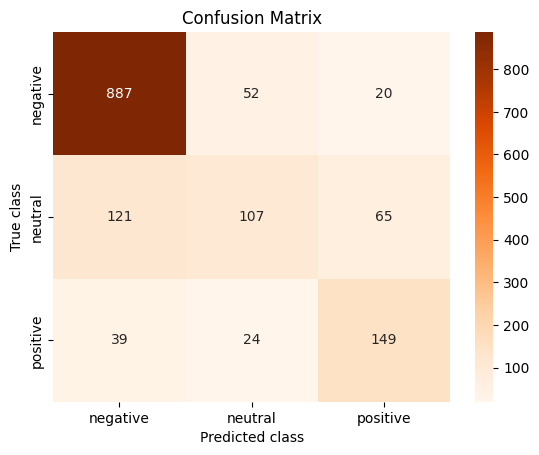

In [414]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 3
output_size = len(label_encoder.classes_)

LSTM_M4 = LSTM(input_size, hidden_size, num_layers,
               output_size, dropoutAdd=True)

# Regularization (L2)
l2_reg = 0.001
criterion_M4 = nn.CrossEntropyLoss()
optimizer_M4 = optim.Adam(LSTM_M4.parameters(), lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=LSTM_M4, criterion=criterion_M4,
                                                                                     optimizer=optimizer_M4, earlyStopping=True)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=LSTM_M4)

### Best model weights LSTM

In [ ]:
# Save model weights with best accuracy for LSTM
torch.save(ResNet18_M1.state_dict(), 'ngupta22_kchavan_assignment1_part_2.pt')

### GRU Model Architecture

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropoutAdd=False):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.dropoutAdd = dropoutAdd
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim,
                          batch_first=True, dropout=0.5 if dropoutAdd else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Add a sequence length dimension
        x = x.unsqueeze(1)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        out, _ = self.gru(x, h0)
        if self.dropoutAdd:
            # Apply dropout
            out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]  # Input size is the number of features
hidden_size = 128  # Number of features in the hidden state
num_layers = 3  # Number of LSTM layers
output_size = len(label_encoder.classes_)  # Output size is the number of classes

In [ ]:
# Print the model architecture
print(GRU(input_size, hidden_size, num_layers, output_size, dropoutAdd=False))

### GRU Model

In [ ]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 3
output_size = len(label_encoder.classes_)

GRU_M1 = LSTM(input_size, hidden_size, num_layers,
               output_size, dropoutAdd=False)

GRU_M1 = nn.CrossEntropyLoss()
GRU_M1 = optim.Adam(GRU_M1.parameters(), lr=0.0001)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=GRU_M1, criterion=GRU_M1,
                                                                                     optimizer=GRU_M1, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=GRU_M1)

### GRU Model with Regularization

In [ ]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 3
output_size = len(label_encoder.classes_)

GRU_M2 = GRU(input_size, hidden_size, num_layers,
               output_size, dropoutAdd=False)

# Regularization (L2)
l2_reg = 0.001
criterion_M2 = nn.CrossEntropyLoss()
optimizer_M2 = optim.Adam(GRU_M2.parameters(), lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=GRU_M2, criterion=criterion_M2,
                                                                                     optimizer=optimizer_M2, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=GRU_M2)

### GRU Model with Regularization and Dropout

In [ ]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 3
output_size = len(label_encoder.classes_)

GRU_M3 = GRU(input_size, hidden_size, num_layers,
               output_size, dropoutAdd=True)

# Regularization (L2)
l2_reg = 0.001
criterion_M3 = nn.CrossEntropyLoss()
optimizer_M3 = optim.Adam(GRU_M3.parameters(), lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=GRU_M3, criterion=criterion_M3,
                                                                                     optimizer=optimizer_M3, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=GRU_M3)

### GRU Model with Regularization, Dropout and Early Stopping

In [ ]:
# Define the input size, hidden size, number of layers, and output size
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 3
output_size = len(label_encoder.classes_)

GRU_M4 = GRU(input_size, hidden_size, num_layers,
               output_size, dropoutAdd=True)

# Regularization (L2)
l2_reg = 0.001
criterion_M4 = nn.CrossEntropyLoss()
optimizer_M4 = optim.Adam(GRU_M4.parameters(), lr=0.0001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=GRU_M4, criterion=criterion_M4,
                                                                                     optimizer=optimizer_M4, earlyStopping=True)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=GRU_M4)

### Best model weights GRU

In [18]:
# Save model weights with best accuracy for GRU
# torch.save(ResNet18_M1.state_dict(), 'ngupta22_kchavan_assignment1_part_2.pt')